# Zero-Shot-Learning Network (Train)

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import gzip
import _pickle as cPikle
from collections import Counter

In [2]:
from sklearn.preprocessing import LabelEncoder, normalize
from sklearn.neighbors import KDTree

In [3]:
import keras
from keras import backend as K
from keras.preprocessing import image
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Dropout
from keras.layers import BatchNormalization
from keras.optimizers import Adam
from keras.utils import to_categorical

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Set Configs

In [4]:
# collect data from visualgenome.org and 
# use 20 classes in total where there are 15 classes selected for training classes and 5 classes selected as Zero-Shot classes
WORD2VEC_PATH = "./datasets/class_vectors.npy" # (class embedding) in numpy data format for 20 defined class to train and test the ZSL model
DATASETS_PATH = "./datasets/zero_shot_data.pkl" # (image embedding) pickle data of extracted feature vectors
MODEL_PATH = "./weights/"

In [5]:
NUM_CLASSES = 15
NUM_ATTRS = 300
BATCH_SIZE = 128
LR = 5e-5
N_EPOCHS = 50
TRAIN_SIZE_PER_CLASS = 300

In [6]:
print("Total class:", len(np.load(WORD2VEC_PATH)))
print("Word2vec dimension:",np.load(WORD2VEC_PATH)[0][1].shape[0])
with gzip.GzipFile(DATASETS_PATH, 'rb') as infile: data = cPikle.load(infile)
print("Total datasets:", len(data))

Total class: 20
Word2vec dimension: 300
Total datasets: 7992


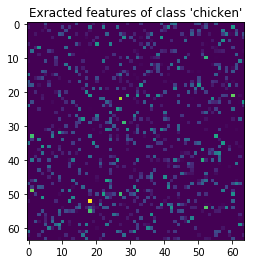

In [7]:
idx_image = 1200
extracted_features_sample = np.reshape(data[idx_image][1], (64,64))
plt.title("Exracted features of class '{}'".format(data[idx_image][0]))
plt.imshow(extracted_features_sample)
plt.show()

## Set Helpers

In [8]:
def save_model(model, model_path):
    if not os.path.exists(model_path):
        os.makedirs(model_path)
        
    model_json = model.to_json()
    with open(model_path + 'zsl_model.json', 'w') as json_file:
        json_file.write(model_json)
        
    model.save_weights(model_path + 'zsl_model.h5')
    print("ZSL model is saved.")
    return

In [9]:
def load_data():
    
    # load datasets in pickle format
    with gzip.GzipFile(DATASETS_PATH, 'rb') as infile:
        data = cPikle.load(infile)
            
    # split data for model training process including zero-shot-data as well
    not_splitted_train_data = [instance for instance in data if instance[0] in train_classes]
    zero_shot_data = [instance for instance in data if instance[0] not in train_classes]
    np.random.shuffle(not_splitted_train_data)
    
    train_size = TRAIN_SIZE_PER_CLASS
    train_data = list()
    valid_data = list()
    
    for class_label in train_classes: # consists 15 training classes
        ct = 0
        for instance in not_splitted_train_data:
            if instance[0] == class_label:
                if ct < train_size:
                    train_data.append(instance)
                    ct += 1
                    continue
                valid_data.append(instance)
                
    np.random.shuffle(train_data) # shuffle 15*300 train data
    np.random.shuffle(valid_data) # shuffle 15*(about)100 valid data
    
    # one-hot encode label data
    label_encoder = LabelEncoder()
    label_encoder.fit(train_classes)
    
    train_data = [(instance[1], to_categorical(label_encoder.transform([instance[0]]), num_classes=NUM_CLASSES)) for instance in train_data]
    valid_data = [(instance[1], to_categorical(label_encoder.transform([instance[0]]), num_classes=NUM_CLASSES)) for instance in valid_data]
    
    # prepare train data
    x_train, y_train = zip(*train_data)
    x_train, y_train = np.squeeze(np.asarray(x_train)), np.squeeze(np.asarray(y_train))
    x_train = normalize(x_train, norm='l2')
    
    # prepare valid data
    x_valid, y_valid = zip(*valid_data)
    x_valid, y_valid = np.squeeze(np.asarray(x_valid)), np.squeeze(np.asarray(y_valid))    
    x_valid = normalize(x_valid, norm='l2')
    
    # prepare zero-shot-data
    y_zsl, x_zsl = zip(*zero_shot_data)
    x_zsl, y_zsl = np.squeeze(np.asarray(x_zsl)), np.squeeze(np.asarray(y_zsl))
    x_zsl = normalize(x_zsl, norm='l2')
    
    print("Data loading is completed.")
    return (x_train, x_valid, x_zsl), (y_train, y_valid, y_zsl)

In [10]:
def custom_kernel_init(shape):
    class_vectors = np.load(WORD2VEC_PATH)
    # load training vectors 15*300
    training_vectors = sorted([(label, vector) for (label, vector) in class_vectors if label in train_classes], key=lambda x: x[0])
    _, vectors = zip(*training_vectors)
    vectors = np.asarray(vectors, dtype=np.float)
    # transpose into 300*15
    vectors = vectors.T
    
    return vectors

In [11]:
def build_model():
    
    model = Sequential()
    model.add(Dense(1024, input_shape=(4096,), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.8))
    
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(256, activation='relu'))
    model.add(Dense(NUM_ATTRS, activation='relu'))
    
    # weights of this layer must be determined using Word2Vecs of the training classes by kernel_initializer 
    # the layer must be set false to be untrainable
    model.add(Dense(NUM_CLASSES, activation='softmax', trainable=False, kernel_initializer=custom_kernel_init))
    
    print("Model is built.")
    return model

In [12]:
def train_model(model, train_data, valid_data):
    
    x_train, y_train = train_data
    x_valid, y_valid = valid_data
    adam = Adam(lr=LR)
    model.compile(loss = 'categorical_crossentropy',
                  optimizer = adam,
                  metrics = ['categorical_accuracy', 'top_k_categorical_accuracy'])
    
    history = model.fit(x_train, y_train,
                        validation_data = (x_valid, y_valid),
                        verbose = 2,
                        epochs = N_EPOCHS,
                        batch_size = BATCH_SIZE,
                        shuffle = True)
    
    print("Model training is completed.")
    return history

In [13]:
def main():
    
    global train_classes
    with open('./classes/train_classes.txt', 'r') as infile:
        train_classes = [str.strip(line) for line in infile]
        
    global zsl_classes
    with open('./classes/zsl_classes.txt', 'r') as infile:
        zsl_classes = [str.strip(line) for line in infile]
    
    # -----------------
    # Training Process
    # -----------------
    (x_train, x_valid, x_zsl), (y_train, y_valid, y_zsl) = load_data()
    model = build_model()
    history = train_model(model, (x_train, y_train), (x_valid, y_valid))
    print(model.summary())
    
    # --------------------------
    # Create and save ZSL model
    # --------------------------
    model_input = model.input
    
    # the model should give a 300-dimensional vector output for each input image
    # remove the last layer of the model which was untrainable and custom-defined
    model_output = model.layers[-2].output
    zsl_model = Model(model_input, model_output)
    print(zsl_model.summary())
    save_model(zsl_model, model_path=MODEL_PATH)
    
    # -------------------------
    # Evaluate ZSL performance
    # -------------------------
    class_vectors = sorted(np.load(WORD2VEC_PATH), key=lambda x: x[0])
    class_names, vectors = zip(*class_vectors)
    class_names = list(class_names)
    vectors = np.asarray(vectors, dtype=np.float)
    
    tree = KDTree(vectors) # build tree of 20 class vectors
    zsl_prediction = zsl_model.predict(x_zsl)
    
    top5, top3, top1 = 0, 0, 0
    for i, prediction in enumerate(zsl_prediction):
        prediction = np.expand_dims(prediction, axis=0)
        dist_5, index_5 = tree.query(prediction, k=5) # use euclidean distance metric to calculate distance
        prediction_labels = [class_names[index] for index in index_5[0]]
        true_label = y_zsl[i]
        if true_label in prediction_labels:
            top5 += 1
        if true_label in prediction_labels[3]:
            top3 += 1
        if true_label in prediction_labels[0]:
            top1 += 1
            
    print("# --------------------------")
    print("# Zero-Shot Learning Score:")
    print("# --------------------------")
    print("Top-5 Accuracy: %.2f%%" % (100. * top5/ float(len(x_zsl))))
    print("Top-3 Accuracy: %.2f%%" % (100. * top3/ float(len(x_zsl))))
    print("Top-1 Accuracy: %.2f%%" % (100. * top1/ float(len(x_zsl))))
    return history

In [14]:
if __name__ == '__main__':
    history = main()

Data loading is completed.
Model is built.
Train on 4500 samples, validate on 1493 samples
Epoch 1/50
 - 7s - loss: 2.8835 - categorical_accuracy: 0.0931 - top_k_categorical_accuracy: 0.4107 - val_loss: 2.4777 - val_categorical_accuracy: 0.2612 - val_top_k_categorical_accuracy: 0.6966
Epoch 2/50
 - 5s - loss: 2.5938 - categorical_accuracy: 0.1551 - top_k_categorical_accuracy: 0.5244 - val_loss: 2.2861 - val_categorical_accuracy: 0.3577 - val_top_k_categorical_accuracy: 0.7997
Epoch 3/50
 - 6s - loss: 2.3826 - categorical_accuracy: 0.2160 - top_k_categorical_accuracy: 0.6267 - val_loss: 2.1020 - val_categorical_accuracy: 0.3791 - val_top_k_categorical_accuracy: 0.8352
Epoch 4/50
 - 5s - loss: 2.2480 - categorical_accuracy: 0.2516 - top_k_categorical_accuracy: 0.6849 - val_loss: 1.9343 - val_categorical_accuracy: 0.4079 - val_top_k_categorical_accuracy: 0.8547
Epoch 5/50
 - 5s - loss: 2.0857 - categorical_accuracy: 0.2862 - top_k_categorical_accuracy: 0.7489 - val_loss: 1.7989 - val_cate

Epoch 43/50
 - 5s - loss: 0.9801 - categorical_accuracy: 0.6369 - top_k_categorical_accuracy: 0.9649 - val_loss: 1.1595 - val_categorical_accuracy: 0.5780 - val_top_k_categorical_accuracy: 0.9498
Epoch 44/50
 - 5s - loss: 0.9552 - categorical_accuracy: 0.6456 - top_k_categorical_accuracy: 0.9631 - val_loss: 1.1567 - val_categorical_accuracy: 0.5807 - val_top_k_categorical_accuracy: 0.9504
Epoch 45/50
 - 5s - loss: 0.9545 - categorical_accuracy: 0.6489 - top_k_categorical_accuracy: 0.9673 - val_loss: 1.1548 - val_categorical_accuracy: 0.5780 - val_top_k_categorical_accuracy: 0.9518
Epoch 46/50
 - 5s - loss: 0.9494 - categorical_accuracy: 0.6480 - top_k_categorical_accuracy: 0.9656 - val_loss: 1.1472 - val_categorical_accuracy: 0.5774 - val_top_k_categorical_accuracy: 0.9504
Epoch 47/50
 - 5s - loss: 0.9479 - categorical_accuracy: 0.6491 - top_k_categorical_accuracy: 0.9687 - val_loss: 1.1498 - val_categorical_accuracy: 0.5774 - val_top_k_categorical_accuracy: 0.9531
Epoch 48/50
 - 5s - 

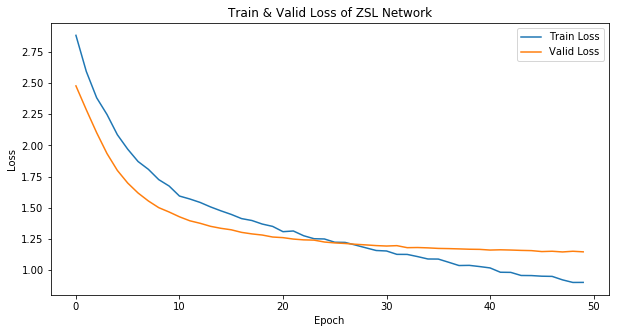

In [15]:
plt.figure(figsize=(10,5))
plt.title("Train & Valid Loss of ZSL Network")
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Valid Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

if not os.path.exists('./images/'): os.makedirs('./images/')
plt.savefig('./images/final_loss.png')
plt.show()

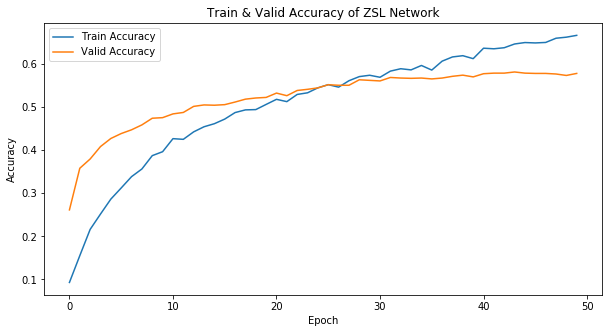

In [16]:
plt.figure(figsize=(10,5))
plt.title("Train & Valid Accuracy of ZSL Network")
plt.plot(history.history['categorical_accuracy'], label="Train Accuracy")
plt.plot(history.history['val_categorical_accuracy'], label="Valid Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

if not os.path.exists('./images/'): os.makedirs('./images/')
plt.savefig('./images/final_categorical_accuracy.png')
plt.show()

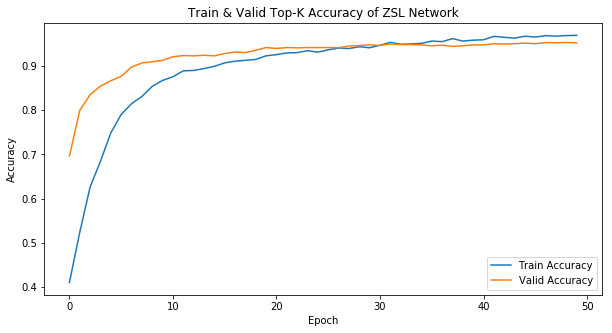

In [17]:
plt.figure(figsize=(10,5))
plt.title("Train & Valid Top-K Accuracy of ZSL Network")
plt.plot(history.history['top_k_categorical_accuracy'], label="Train Accuracy")
plt.plot(history.history['val_top_k_categorical_accuracy'], label="Valid Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

if not os.path.exists('./images/'): os.makedirs('./images/')
plt.savefig('./images/final_categorical_top_k_accuracy.png')
plt.show()

---